In [1]:
%matplotlib inline
%load_ext watermark
%watermark -v -m -p numpy,scipy,pandas,matplotlib,seaborn,sklearn,pywt 

CPython 3.5.2
IPython 5.1.0

numpy 1.11.1
scipy 0.18.0
pandas 0.18.1
matplotlib 1.5.1
seaborn 0.7.1
sklearn 0.19.dev0
pywt 0.4.0

compiler   : GCC 4.2.1 Compatible Apple LLVM 4.2 (clang-425.0.28)
system     : Darwin
release    : 16.0.0
machine    : x86_64
processor  : i386
CPU cores  : 4
interpreter: 64bit


In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
# import seaborn as sns

from pandas import set_option
set_option("display.max_rows", 10)
pd.options.mode.chained_assignment = None

### Original variables
Here we uplaoad the original variables `facies_vectors.csv`

In [3]:
filename = 'data/facies_vectors.csv'
training_data_raw = pd.read_csv(filename)

# Change variable type
training_data_raw['Well Name'] = training_data_raw['Well Name'].astype('category')
training_data_raw['Formation'] = training_data_raw['Formation'].astype('category')
# Check how many wells
training_data_raw['Well Name'].unique()

training_data_raw.to_pickle('data/training_data_raw.pkl')

### Wavelet decomposition
We compute the approximation coefficients vector cA and detail coefficients vector cD, obtained by a wavelet decomposition of each logs, i.e. `GR`, `ILD_log10`, `DeltaPHI`, `PHIND`, `PE`. Next figure shows the cofficient cA and cD as well as `GR` for the `SHANKLE`well.

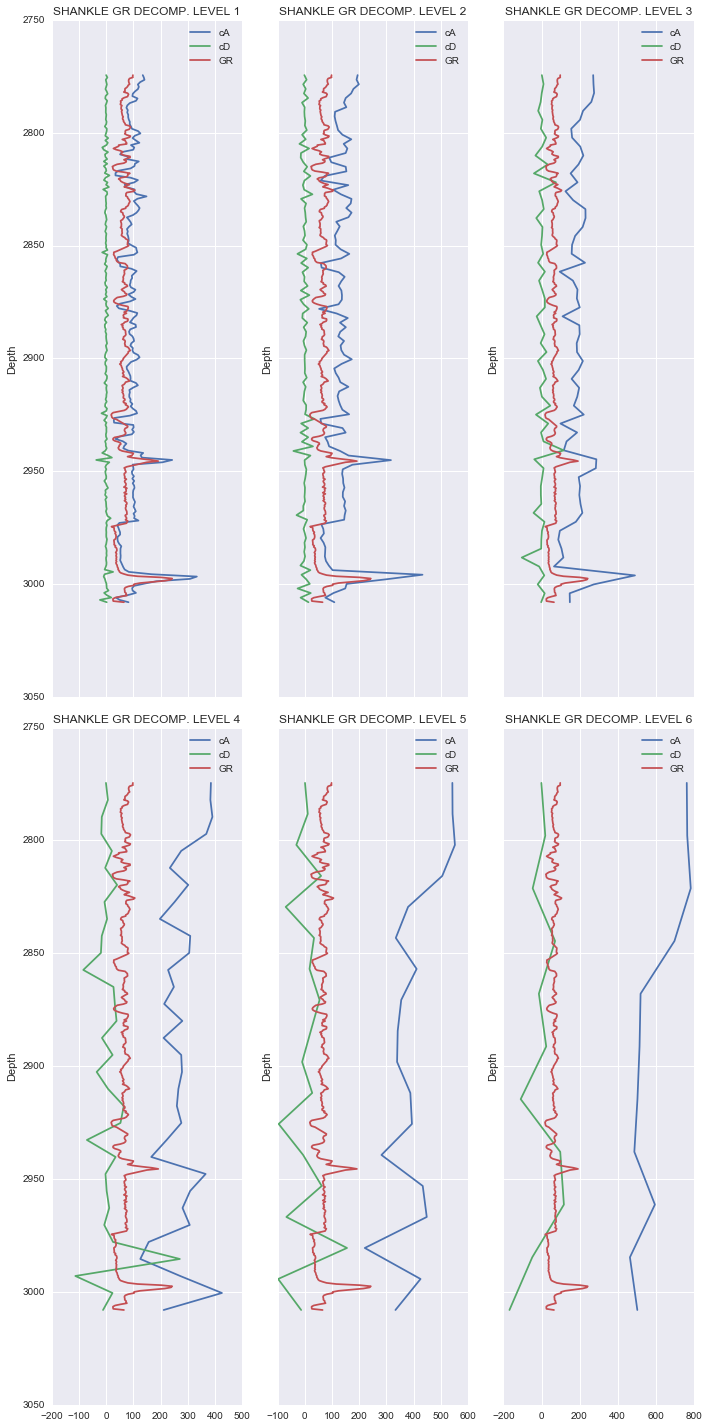

In [4]:
import pywt
from scipy.interpolate import interp1d

grouped = training_data_raw.groupby(['Well Name'])
db3 = pywt.Wavelet('db3')
data = grouped.get_group('SHANKLE').GR
depth = grouped.get_group('SHANKLE').Depth

n_levels = 6
nrows = 2
fig, axs = plt.subplots(figsize=(10,20),
                        nrows=nrows, ncols=3,
                        sharey='row',sharex='col') # Much control of gridspec
for i in range(nrows):
    axs[i,0].invert_yaxis()


temp_data = data
for i,ax in zip(range(1,n_levels+1),axs.flatten()):
    
    cA,cD = pywt.dwt(temp_data,db3,mode='symmetric')
    ax.plot(cA,np.linspace(min(depth),max(depth),len(cA)))
    ax.plot(cD,np.linspace(min(depth),max(depth),len(cD)))
    ax.plot(data,depth)
    ax.set_title('SHANKLE GR DECOMP. LEVEL %d' % (i))
    ax.set_ylabel('Depth')
    ax.legend(['cA','cD','GR'])
    plt.tight_layout()
    temp_data = cA

In [5]:
n_levels = 6
new_vars = pd.DataFrame()

for key in grouped.groups.keys():
    
    depth = grouped.get_group(key)['Depth']
    temp_df = pd.DataFrame()
    temp_df['Depth'] = depth
    for log in ['GR','ILD_log10','DeltaPHI','PHIND','PE']:
      
        temp_data = grouped.get_group(key)[log]
        
        for i in range(1,n_levels+1):

            cA,cD = pywt.dwt(temp_data,db3,mode='symmetric')

            new_depth = np.linspace(min(depth),max(depth),len(cD))
#             f1 = interp1d(new_depth,cD,kind='linear')
            f2 = interp1d(new_depth,cD,kind='nearest')
#             f3 = interp1d(new_depth,cA,kind='linear')

#             temp_df[log + '_cD_lin_level_' + str(i)] = f1(depth)
            temp_df[log + '_cD_step_level_' + str(i)] = f2(depth)
#             temp_df[log + '_cA_level_' + str(i)] = f3(depth)
    
    temp_df['Well Name'] = [key for _ in range(len(depth))]
    new_vars = new_vars.append(temp_df)

new_vars = new_vars.sort_index()
new_vars.to_pickle('data/vars_from_dwt.pkl')

### Entropy calculation
Entropy 

In [ ]:
del new_vars
from skimage.filters.rank import entropy
from skimage.morphology import rectangle
from skimage.util import img_as_ubyte

new_vars = pd.DataFrame()
l_foot = 5
footprint = rectangle(l_foot,3)

for key in grouped.groups.keys():
    
    depth = grouped.get_group(key)['Depth']
    temp_df = pd.DataFrame()
    temp_df['Depth'] = depth
    for log in ['GR','ILD_log10','DeltaPHI','PHIND','PE']:
      
        temp_data = grouped.get_group(key)[log]
        
        image = np.vstack((temp_data,temp_data,temp_data))
        image -= np.median(image) 
        image /= np.max(np.abs(image))
        image = img_as_ubyte(image)
        
        temp_df[log + '_entropy_foot' + str(l_foot)] = entropy(image,footprint)[0,:]
    
    temp_df['Well Name'] = [key for _ in range(len(depth))]
    new_vars = new_vars.append(temp_df)
    
new_vars = new_vars.sort_index()
new_vars.to_pickle('data/vars_from_log_entropy.pkl')